# Spike Triggered Average in TensorFlow

The data is an experimentally recorded set of spikes recorded from the famous H1 motion-sensitive neuron of the fly (Calliphora vicina) from the lab of Dr Robert de Ruyter van Steveninck.

Here we use TensorFlow to find out how the neuron is reacting to the data, to see what causes the neuron to trigger.

In [2]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
sess = tf.InteractiveSession()

FILENAME = 'data.pickle'

with open(FILENAME, 'rb') as f:
    data = pickle.load(f)

stim = tf.constant(data['stim'])
rho = tf.constant(data['rho'])
sampling_period = 2 # The data was sampled at 500hz = 2ms
window_size = 150 # Let's use a 300ms / sampling_period sliding window

We now have our data loaded into tensorflow as a constant, which means that we can easily 'run' our tensorflow graph.  For example, let's examine stim and rho:

In [3]:
print("Spike-train time-series =", rho.eval(), "\nStimulus time-series    =", stim.eval())

Spike-train time-series = [0 0 0 ..., 0 0 0] 
Stimulus time-series    = [-111.94824219  -81.80664062   10.21972656 ...,    9.78515625   24.11132812
   50.25390625]


rho is an binary array where a 1 indicates a spike.  Let's turn that into an array of indices of where the value is 1, but ignoring the first window_size elements.

**Note:** We can use the [] and + operations on a tensorflow variable, and it correctly adds those operations to the graph.  This is equivalent to using  the tf.slice and tf.add operations.

In [4]:
spike_times = tf.where(tf.not_equal(rho[window_size:-1], 0)) + window_size
print("Time indices where there is a spike:\n", spike_times.eval())

Time indices where there is a spike:
 [[   158]
 [   160]
 [   162]
 ..., 
 [599936]
 [599941]
 [599947]]


In [5]:
def getStimWindow(index):
    i = tf.cast(index, tf.int32)
    return stim[i-window_size+1:i+1]
stim_windows = tf.map_fn(lambda x: getStimWindow(x[0]), spike_times, dtype=tf.float64)
spike_triggered_average = tf.reduce_mean(stim_windows, 0).eval()
print("Spike triggered averaged is:", spike_triggered_average[0:5], "(truncated)")

Spike triggered averaged is: [-0.33083048 -0.29083503 -0.23076012 -0.24636984 -0.10962767] (truncated)


Now let's plot this!

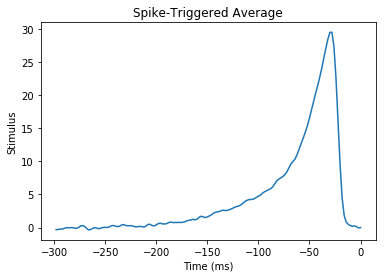

In [6]:
time = (np.arange(-window_size, 0) + 1) * sampling_period
plt.plot(time, spike_triggered_average)
plt.xlabel('Time (ms)')
plt.ylabel('Stimulus')
plt.title('Spike-Triggered Average')

plt.show()

It's...  **beautiful**!

What we are looking at here, is that we've discovered that our neuron is doing a [leaky integration](https://en.wikipedia.org/wiki/Leaky_integrator) of the stimulus.  And when that integration adds up to a certain value, it triggers.